In [49]:
# Essentials
import numpy as np
import pandas as pd

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Stats
from scipy.stats import skew, norm, boxcox_normmax, skewtest
from scipy.special import boxcox1p

# Misc
import optuna
from optuna.samplers import TPESampler
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline

# Models
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
import xgboost as xgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# Some Observations

In [3]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


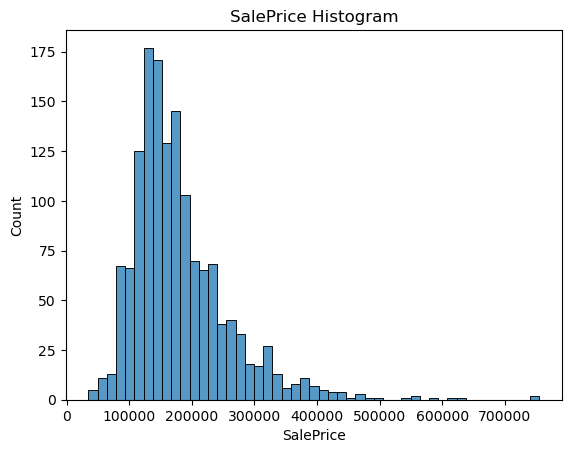

<Figure size 640x480 with 0 Axes>

In [4]:
print(df_train['SalePrice'].describe())
plt.figure()
sns.histplot(df_train['SalePrice'])
plt.title('SalePrice Histogram')
plt.show()
plt.savefig('pics/plot1.png')

In [5]:
print(f"skewness: {df_train['SalePrice'].skew()}")

skewness: 1.8828757597682129


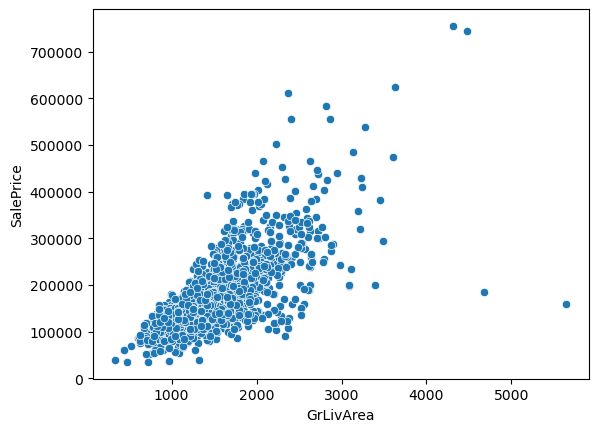

In [6]:
sns.scatterplot(data=df_train, x='GrLivArea', y='SalePrice') # Above grade (ground) living area square feet
plt.savefig('pics/plot2.png')

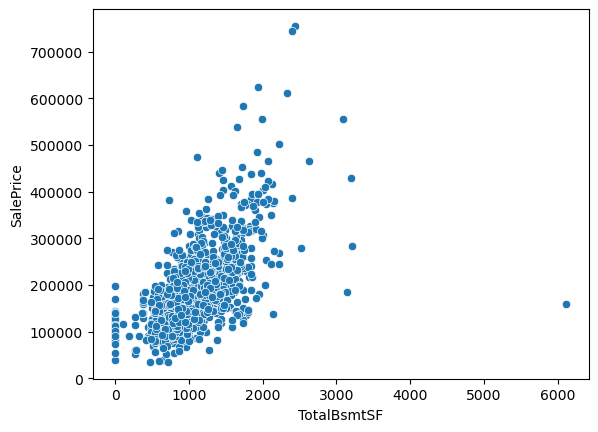

In [7]:
sns.scatterplot(data=df_train, x='TotalBsmtSF', y='SalePrice') # Total square feet of basement area
plt.savefig('pics/plot3.png')

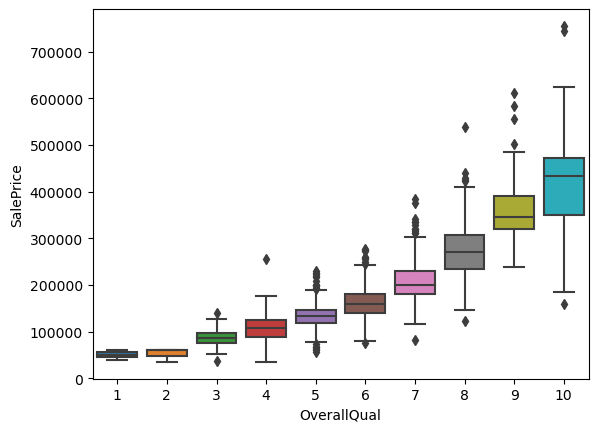

In [8]:
sns.boxplot(data=df_train, x='OverallQual', y='SalePrice') # Overall material and finish quality
plt.savefig('pics/plot4.png')

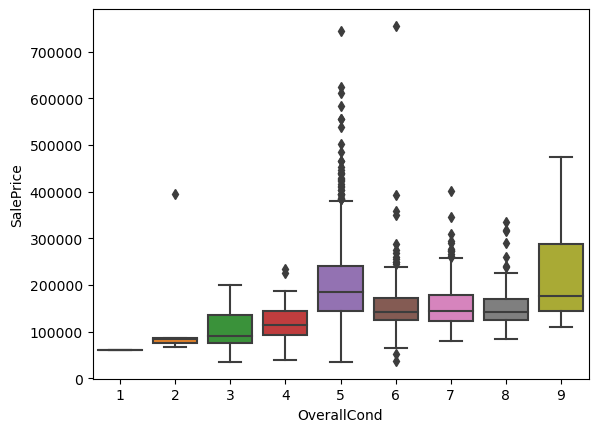

In [9]:
sns.boxplot(data=df_train, x='OverallCond', y='SalePrice') # Overall condition rating
plt.savefig('pics/plot5.png')

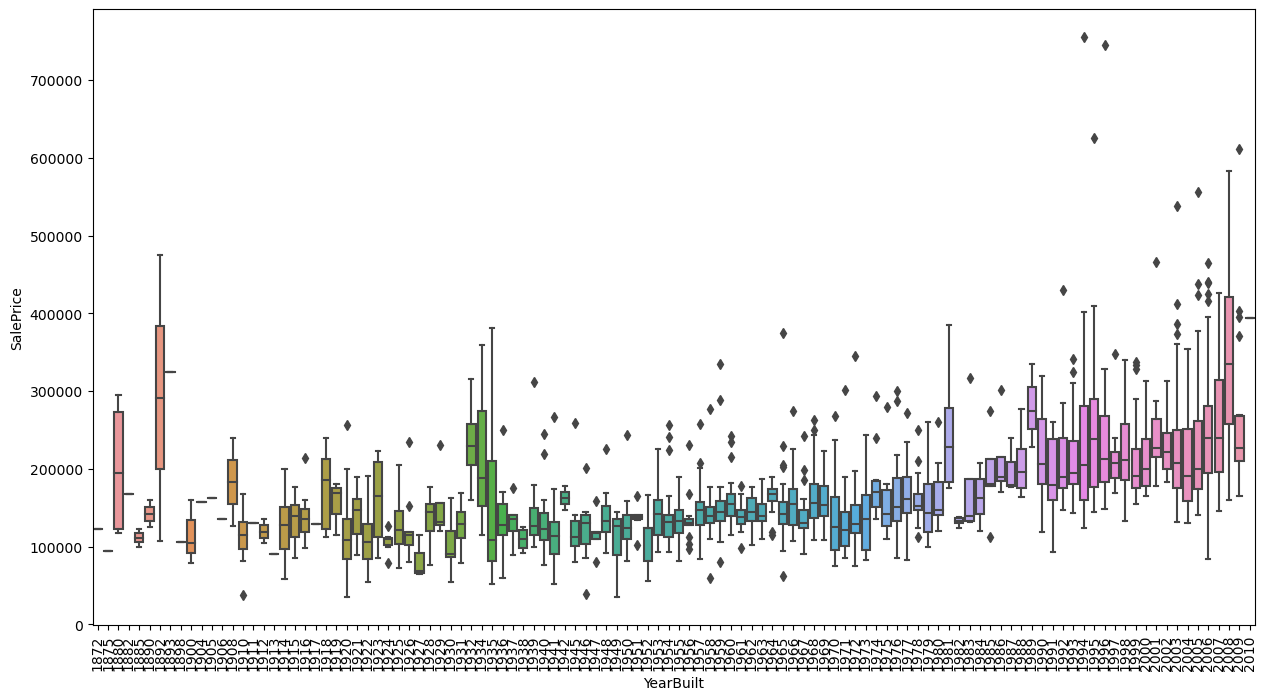

<Figure size 640x480 with 0 Axes>

In [10]:
f, ax = plt.subplots(figsize=(15, 8))
f = sns.boxplot(data=df_train, x='YearBuilt', y='SalePrice') # Original construction date
plt.xticks(rotation=90)
plt.show()
plt.savefig('pics/plot6.png')

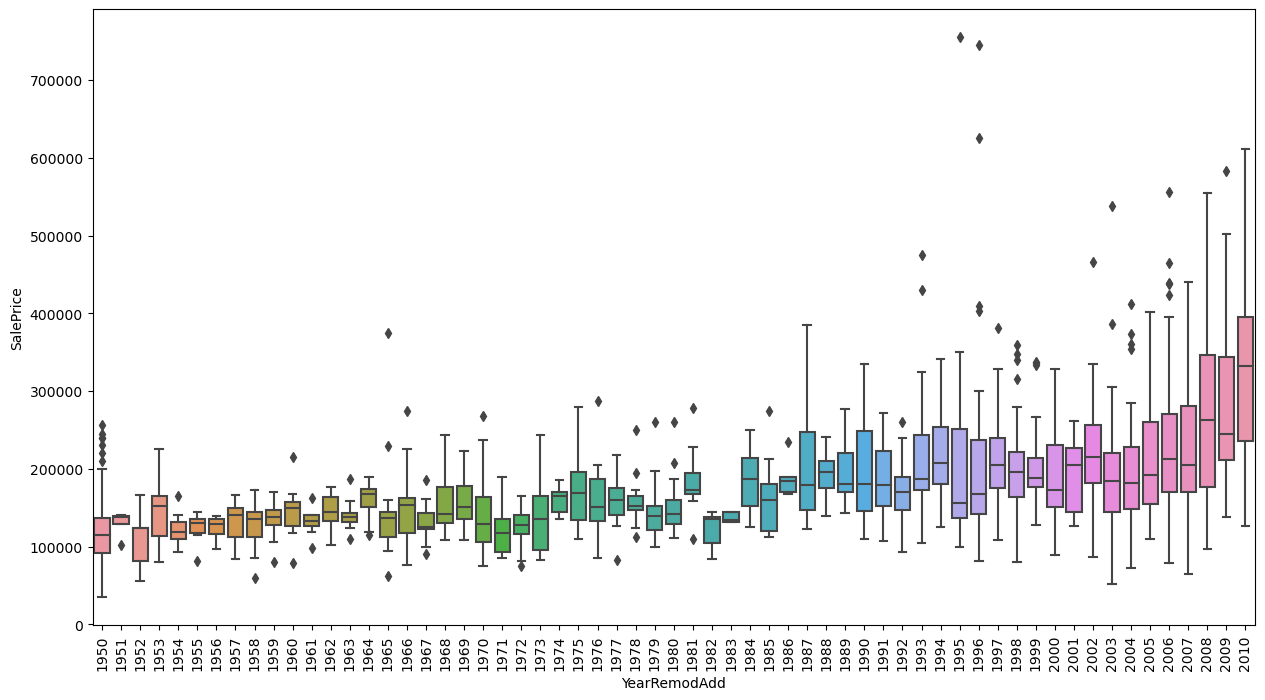

<Figure size 640x480 with 0 Axes>

In [11]:
f, ax = plt.subplots(figsize=(15, 8))
f = sns.boxplot(data=df_train, x='YearRemodAdd', y='SalePrice') # Remodel date
plt.xticks(rotation=90)
plt.show()
plt.savefig('pics/plot7.png')

# Correlation

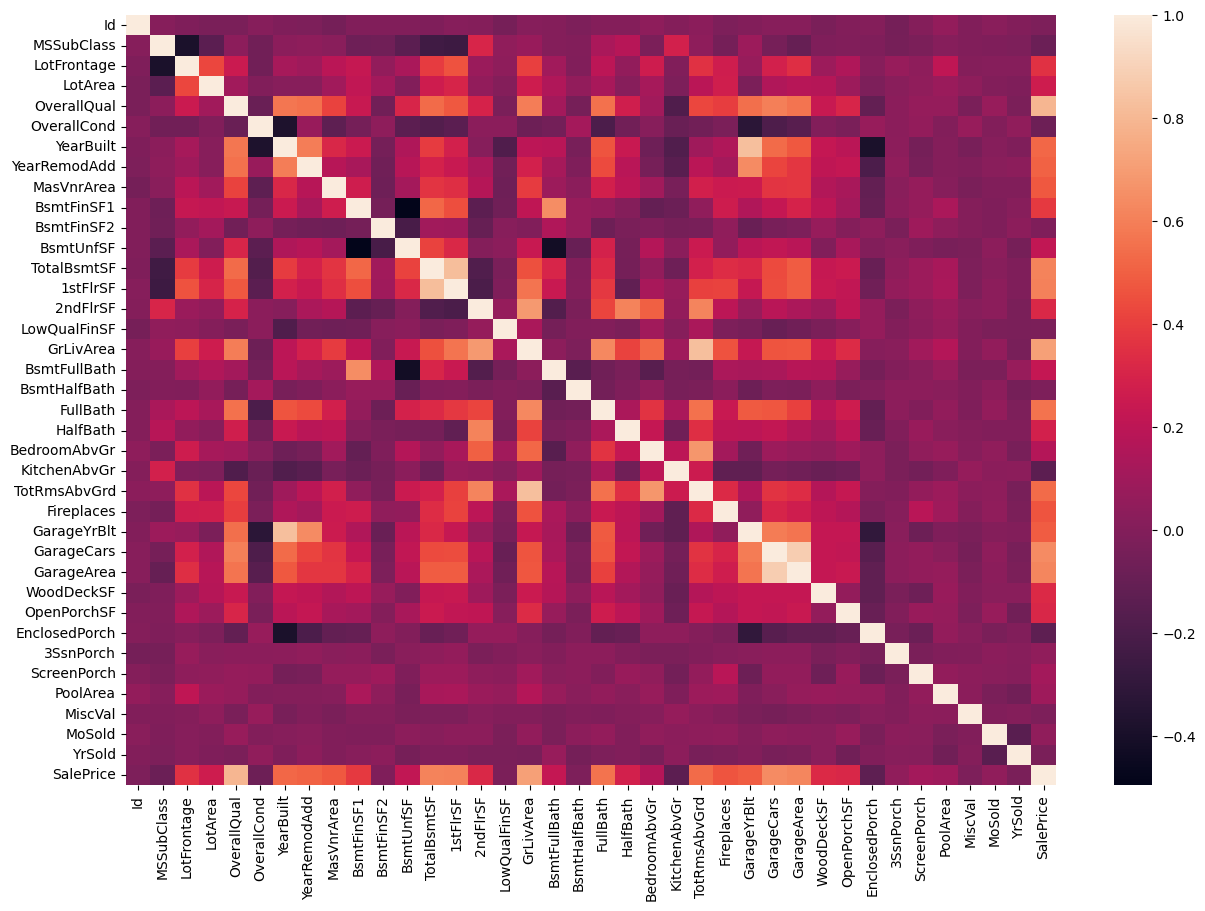

In [12]:
corr = df_train.corr() # correlation
f, ax = plt.subplots(figsize=(15, 10))
f = sns.heatmap(corr)
plt.savefig('pics/plot8.png')

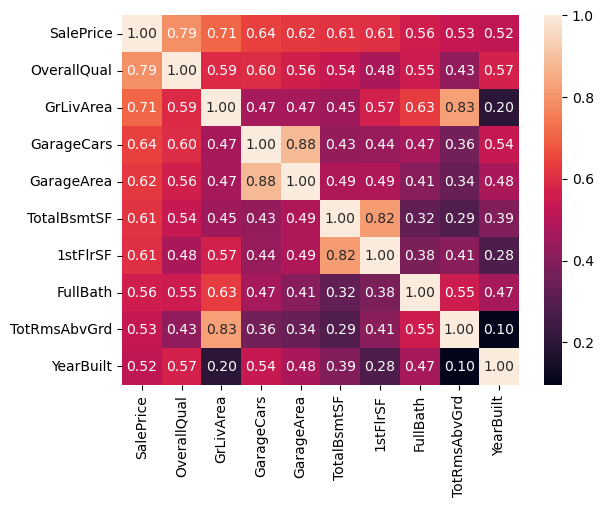

In [13]:
cols = corr.nlargest(10, 'SalePrice')['SalePrice'].index # Columns of 10 largest corr with SalePrice
cm = np.corrcoef(df_train[cols].T) # Transpose to fit the input shape of corrcoef function
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=cols, yticklabels=cols)
plt.savefig('pics/plot9.png')

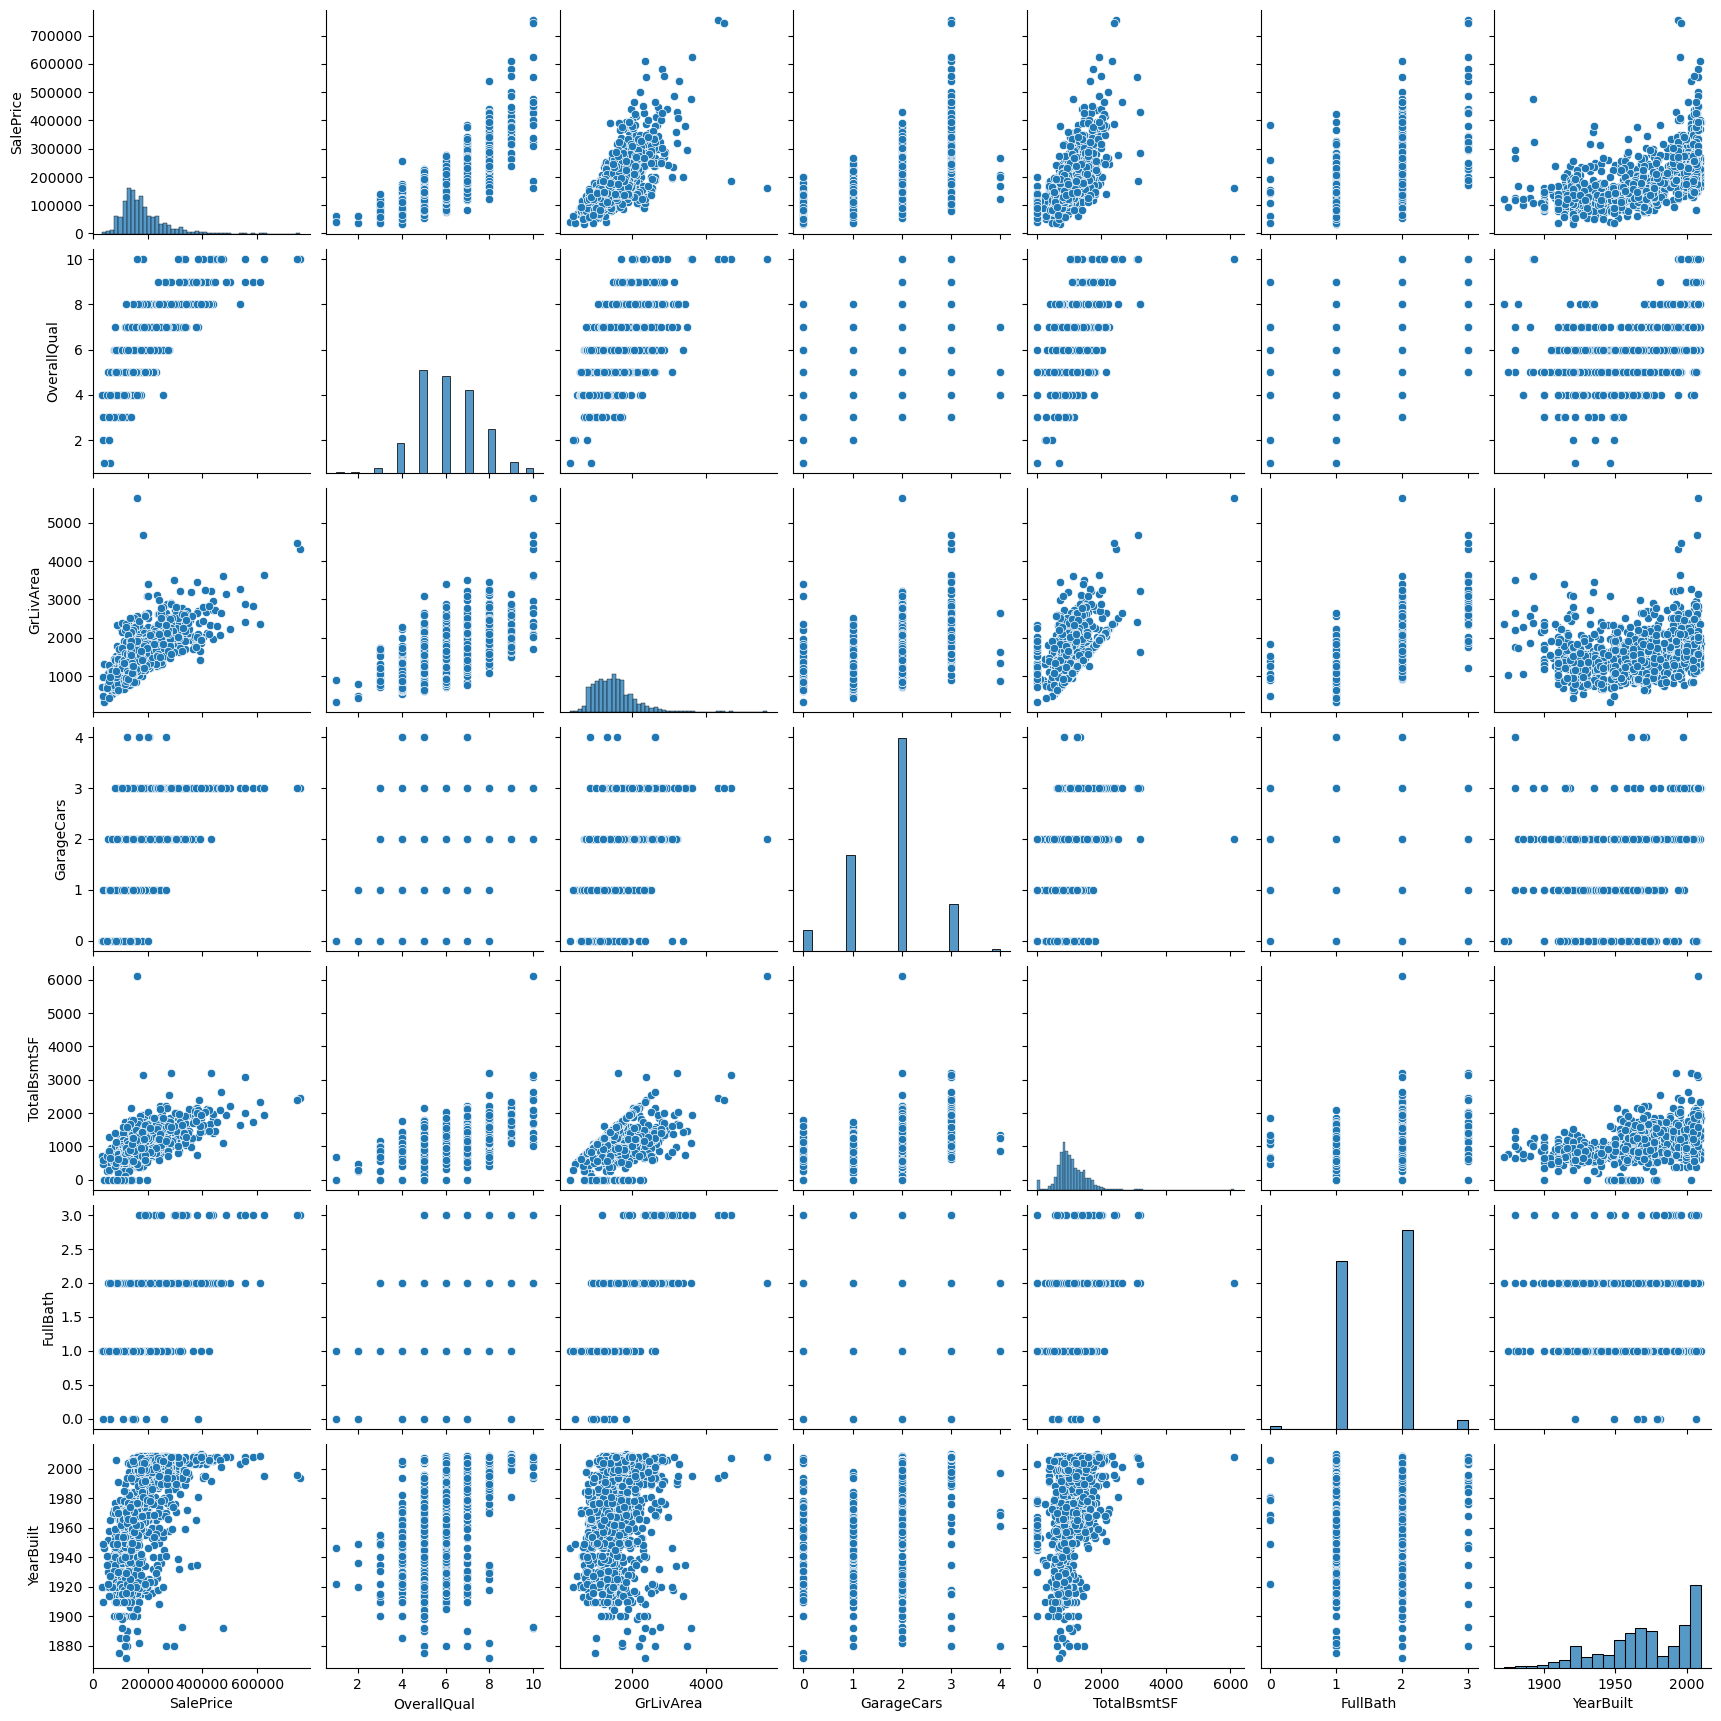

<Figure size 640x480 with 0 Axes>

In [14]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols])
plt.show()
plt.savefig('pics/plot10.png')

# Outliers

In [15]:
print(f'MIN 10 Prices: ')
print(df_train['SalePrice'][df_train['SalePrice'][:].argsort()][:10])
print('========================')
print(f'MAX 10 prices: ')
print(df_train['SalePrice'][df_train['SalePrice'][:].argsort()][-10:])

MIN 10 Prices: 
495     34900
916     35311
968     37900
533     39300
30      40000
710     52000
1337    52500
705     55000
1325    55000
812     55993
Name: SalePrice, dtype: int64
MAX 10 prices: 
798     485000
178     501837
769     538000
440     555000
1046    556581
803     582933
898     611657
1169    625000
1182    745000
691     755000
Name: SalePrice, dtype: int64


In [16]:
df_train.drop(df_train[df_train['GrLivArea']>4500].index, inplace=True)
df_train.reset_index(drop=True, inplace=True)

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

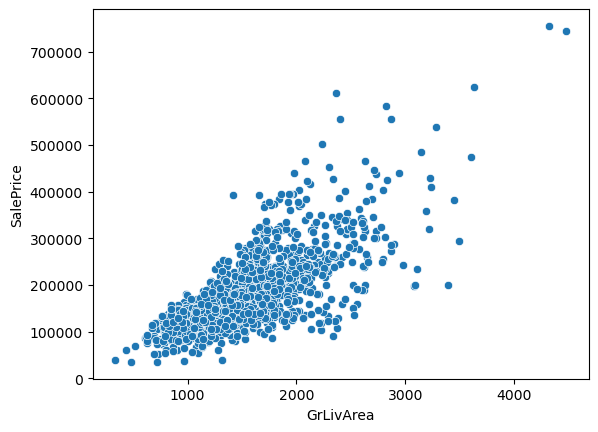

In [17]:
sns.scatterplot(data=df_train, x='GrLivArea', y='SalePrice')

<Axes: xlabel='OverallQual', ylabel='SalePrice'>

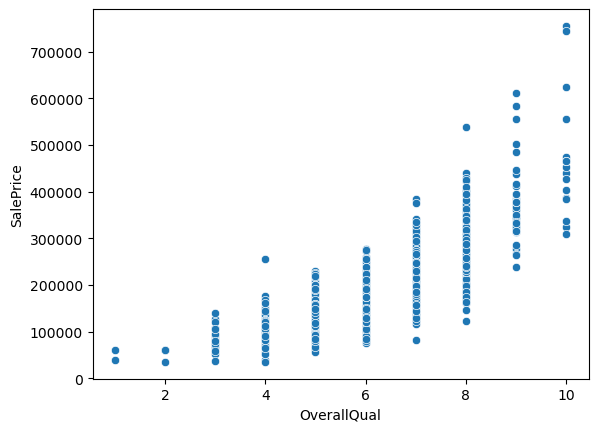

In [18]:
sns.scatterplot(data=df_train, x='OverallQual', y='SalePrice')

<Axes: xlabel='TotalBsmtSF', ylabel='SalePrice'>

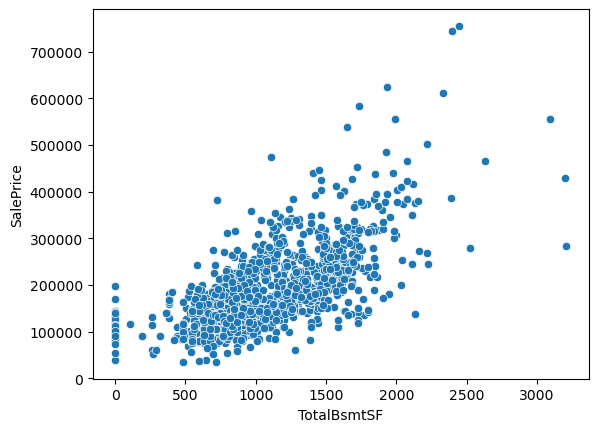

In [19]:
sns.scatterplot(data=df_train, x='TotalBsmtSF', y='SalePrice')

# Missing Data

In [20]:
train_ID = df_train['Id']
test_ID = df_test['Id']
df_train.drop('Id', axis=1, inplace=True)
df_test.drop('Id', axis=1, inplace=True)

In [21]:
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

In [22]:
train_y = df_train['SalePrice'].reset_index(drop=True)
train_x = df_train.drop('SalePrice', axis=1)

all_features = pd.concat([train_x, df_test]).reset_index(drop=True)
all_features.shape

(2917, 79)

In [23]:
len(train_ID), len(test_ID)

(1458, 1459)

In [24]:
missing = all_features.isnull().sum().sort_values(ascending=False)
total = all_features.isnull().count().sort_values(ascending=False)
percent = missing/total
missing_data = pd.concat([missing, percent], axis=1, keys=['count', 'percent'])
missing_data.head(10)

,count,percent
PoolQC,2908,0.996915
MiscFeature,2812,0.964004
Alley,2719,0.932122
Fence,2346,0.804251
FireplaceQu,1420,0.486802
LotFrontage,486,0.166610
GarageYrBlt,159,0.054508
GarageFinish,159,0.054508
GarageQual,159,0.054508
GarageCond,159,0.054508


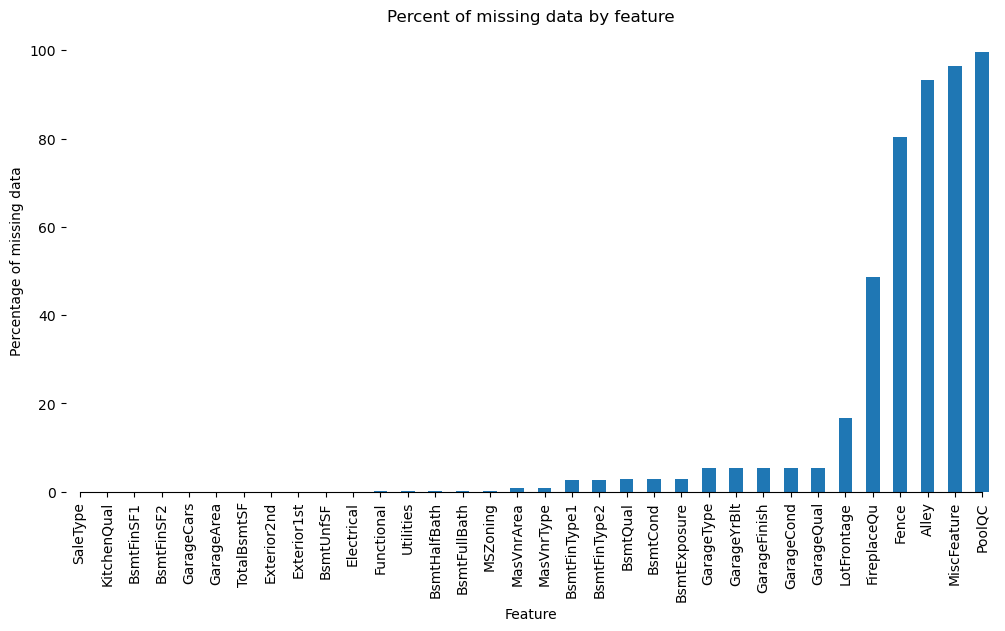

In [25]:
percent = percent[percent>0]*100 # 결측치가 존재하는 데이터만 
f, ax = plt.subplots(figsize=(12,6))
f = percent.sort_values().plot.bar()
ax.set(xlabel='Feature')
ax.set(ylabel='Percentage of missing data')
ax.set(title='Percent of missing data by feature')
sns.despine(trim=True, left=True) # 테두리 없애기

In [26]:
cols = all_features.columns
for col in cols:
    print(f'feature: {col}, data type: {all_features[col].dtype}')

feature: MSSubClass, data type: int64
feature: MSZoning, data type: object
feature: LotFrontage, data type: float64
feature: LotArea, data type: int64
feature: Street, data type: object
feature: Alley, data type: object
feature: LotShape, data type: object
feature: LandContour, data type: object
feature: Utilities, data type: object
feature: LotConfig, data type: object
feature: LandSlope, data type: object
feature: Neighborhood, data type: object
feature: Condition1, data type: object
feature: Condition2, data type: object
feature: BldgType, data type: object
feature: HouseStyle, data type: object
feature: OverallQual, data type: int64
feature: OverallCond, data type: int64
feature: YearBuilt, data type: int64
feature: YearRemodAdd, data type: int64
feature: RoofStyle, data type: object
feature: RoofMatl, data type: object
feature: Exterior1st, data type: object
feature: Exterior2nd, data type: object
feature: MasVnrType, data type: object
feature: MasVnrArea, data type: float64
featu

In [27]:
percent[percent>0].index

Index(['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'Electrical', 'Exterior1st', 'Exterior2nd',
       'Fence', 'FireplaceQu', 'Functional', 'GarageArea', 'GarageCars',
       'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt',
       'KitchenQual', 'LotFrontage', 'MSZoning', 'MasVnrArea', 'MasVnrType',
       'MiscFeature', 'PoolQC', 'SaleType', 'TotalBsmtSF', 'Utilities'],
      dtype='object')

In [28]:
# no Alley access
all_features['Alley'] = all_features['Alley'].fillna('None')

# no Bsmt
for col in ['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual']:
    all_features[col] = all_features[col].fillna('None')
for col in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'TotalBsmtSF']:
    all_features[col] = all_features[col].fillna(0)
    
# standard Electrical
all_features['Electrical'] = all_features['Electrical'].fillna('SBrkr')

# mode Exterior
all_features['Exterior1st'] = all_features['Exterior1st'].fillna(all_features['Exterior1st'].mode()[0])
all_features['Exterior2nd'] = all_features['Exterior2nd'].fillna(all_features['Exterior2nd'].mode()[0])

# no Fence
all_features['Fence'] = all_features['Fence'].fillna('None')

# no Fireplace
all_features['FireplaceQu'] = all_features['FireplaceQu'].fillna('None')

# Functional : Assume typical unless deductions are warranted (from data_description.txt)
all_features['Functional'] = all_features['Functional'].fillna('Typ')

# no Garage
for col in ['GarageArea', 'GarageCars', 'GarageYrBlt']:
    all_features[col] = all_features[col].fillna(0)
for col in ['GarageCond', 'GarageFinish', 'GarageQual', 'GarageType']:
    all_features[col] = all_features[col].fillna('None')

# average KitchenQual
all_features['KitchenQual'] = all_features['KitchenQual'].fillna('TA')

# LotFrontage median of Neighborhood
all_features['LotFrontage'] = all_features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# MSZoning mode of MSSubClass
all_features['MSZoning'] = all_features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

# no Masonry veneer
all_features['MasVnrArea'] = all_features['MasVnrArea'].fillna(0)
all_features['MasVnrType'] = all_features['MasVnrType'].fillna('None')

# no Miscellaneous
all_features['MiscFeature'] = all_features['MiscFeature'].fillna('None')

# no Pool
all_features['PoolQC'] = all_features['PoolQC'].fillna('None')

# unknown SaleType
all_features['SaleType'] = all_features['SaleType'].fillna('Oth')

# Utilities mode of Neighborhood
all_features['Utilities'] = all_features.groupby('Neighborhood')['Utilities'].transform(lambda x: x.fillna(x.mode()[0]))

In [29]:
# convert numeric features that are not numeric to string
all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['YrSold'] = all_features['YrSold'].apply(str)
all_features['MoSold'] = all_features['MoSold'].apply(str)

In [30]:
if all_features.isnull().sum().max()==0:
    print('No remaining missing data')
else:
    print('DIG IN MORE')

No remaining missing data


# Normalize Data

In [31]:
data_types = []
for col in all_features.columns:
    if all_features[col].dtype not in data_types: data_types.append(all_features[col].dtype)
data_types

[dtype('O'), dtype('float64'), dtype('int64')]

In [32]:
# Continuous features
numeric_features = []
for col in all_features.columns:
    if all_features[col].dtype in ['float64', 'int64']: numeric_features.append(col)
   
# Select features of skewness bigger than 0.5    
skew = all_features[numeric_features].apply(lambda x: x.skew()).sort_values(ascending=False)
high_skew = skew[skew > 0.5]
high_skew_index = high_skew.index

print(f'There are {len(high_skew_index)} skewed features')
print('----------------------------')
print(high_skew.head(10))    

There are 25 skewed features
----------------------------
MiscVal          21.950962
PoolArea         17.697766
LotArea          13.116240
LowQualFinSF     12.090757
3SsnPorch        11.377932
KitchenAbvGr      4.302763
BsmtFinSF2        4.146636
EnclosedPorch     4.004404
ScreenPorch       3.947131
BsmtHalfBath      3.932018
dtype: float64


In [33]:
# compute optimal lambda for boxcox using normmax
for col in high_skew_index:
    all_features[col] = boxcox1p(all_features[col], boxcox_normmax(all_features[col]+1))

In [34]:
all_features[numeric_features].apply(lambda x: x.skew()).sort_values(ascending=False)

PoolArea         15.603081
3SsnPorch         8.866605
LowQualFinSF      8.496985
MiscVal           5.240678
BsmtHalfBath      3.781379
KitchenAbvGr      3.780280
ScreenPorch       3.154254
BsmtFinSF2        2.579656
EnclosedPorch     2.150238
MasVnrArea        0.978121
2ndFlrSF          0.895914
WoodDeckSF        0.785954
HalfBath          0.733002
OpenPorchSF       0.621551
BsmtFullBath      0.616960
Fireplaces        0.553419
OverallCond       0.382653
BsmtFinSF1        0.366175
BedroomAbvGr      0.326736
TotalBsmtSF       0.297162
GarageArea        0.216968
OverallQual       0.189688
FullBath          0.165599
LotFrontage       0.059219
BsmtUnfSF         0.054223
TotRmsAbvGrd      0.047214
GrLivArea         0.008827
1stFlrSF         -0.007826
LotArea          -0.138188
GarageCars       -0.219410
YearRemodAdd     -0.450365
YearBuilt        -0.599503
GarageYrBlt      -3.906642
dtype: float64

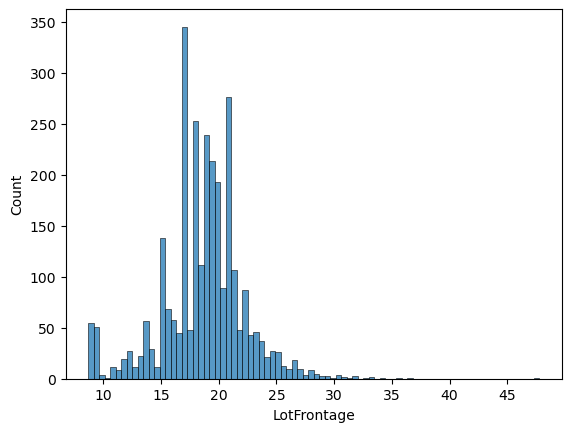

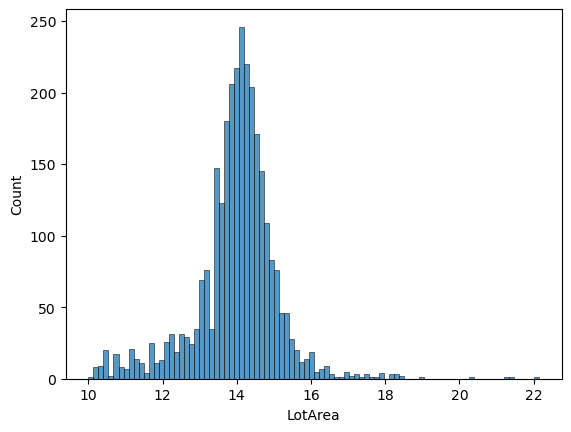

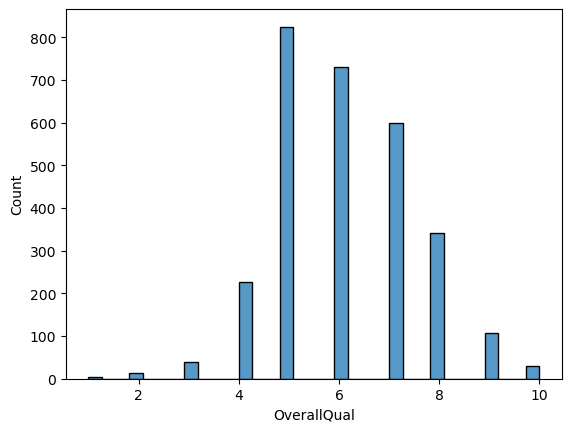

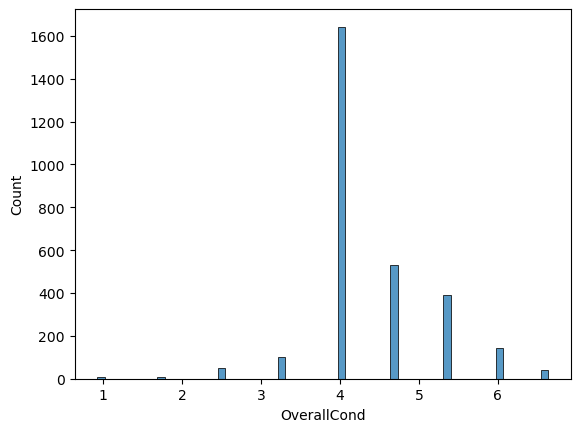

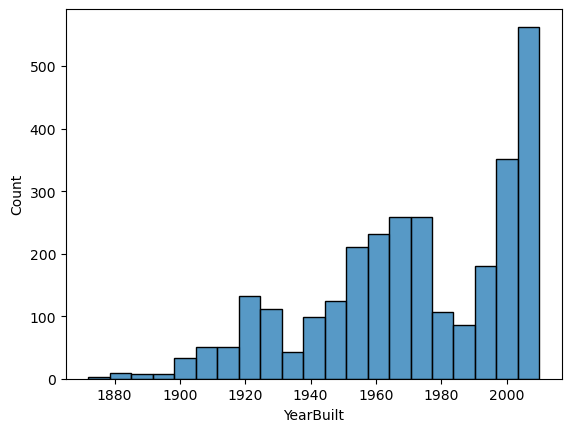

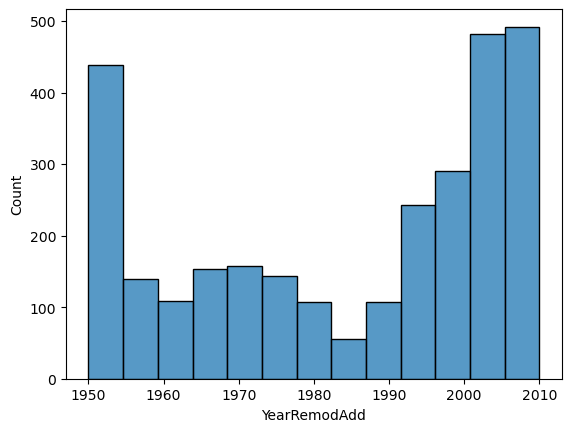

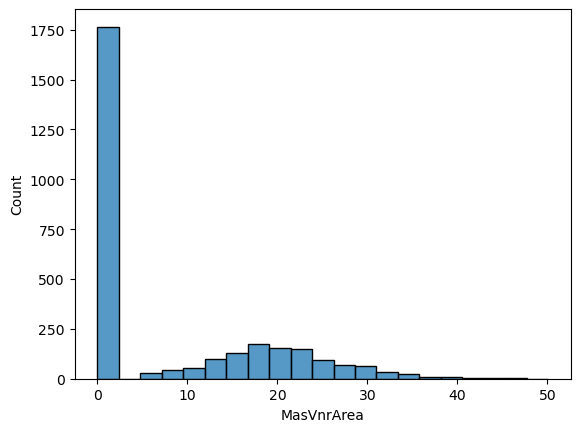

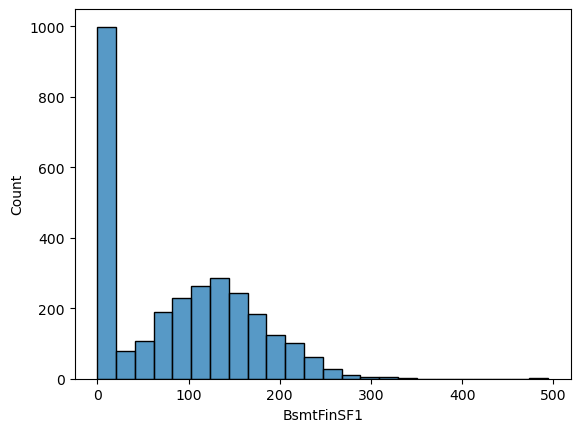

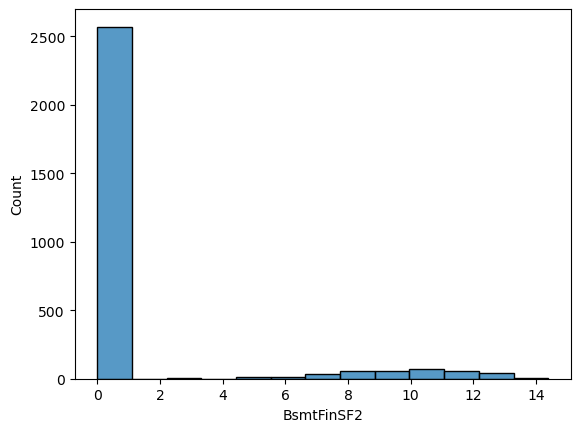

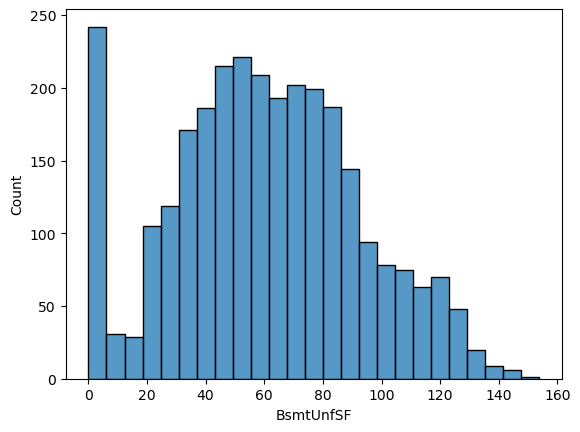

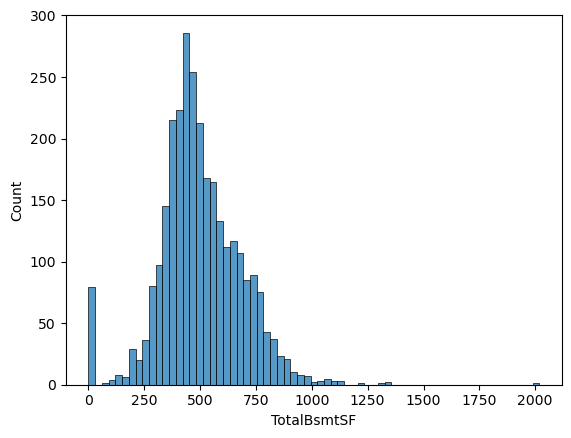

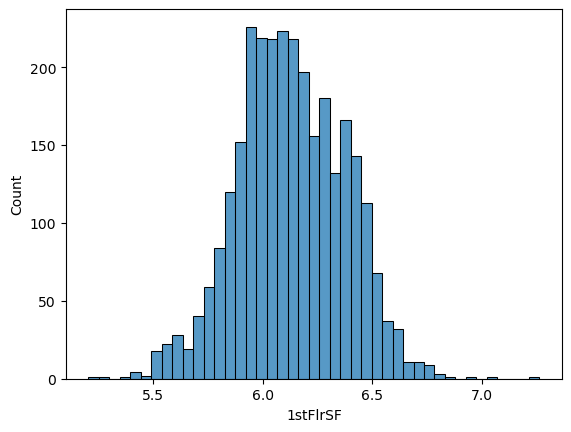

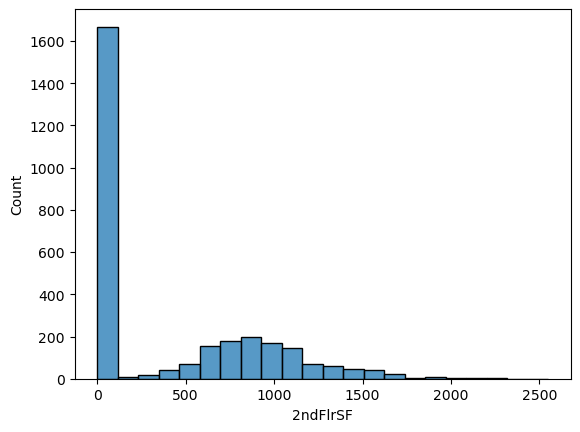

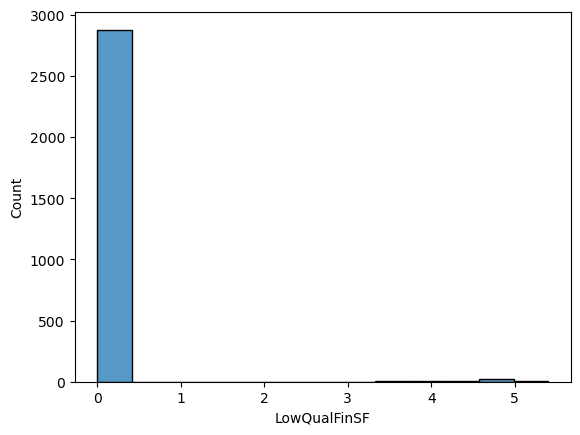

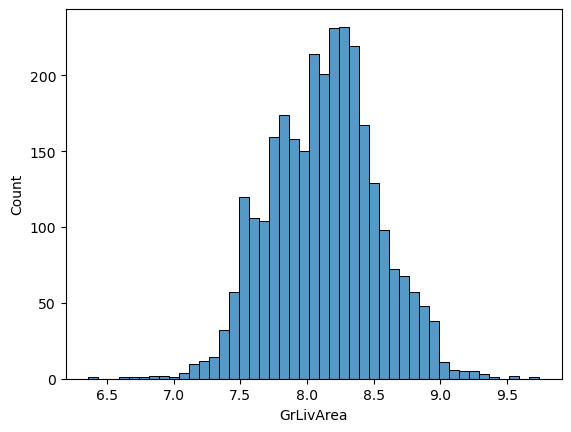

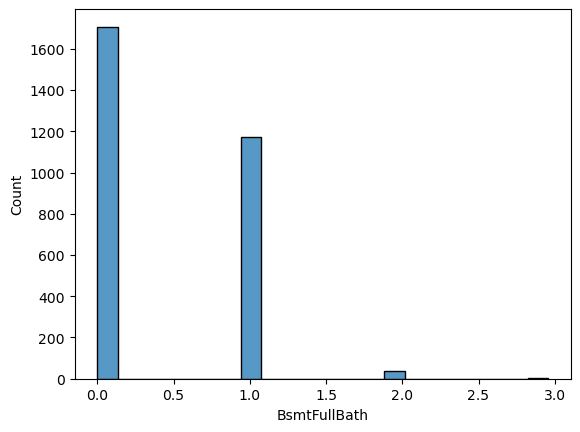

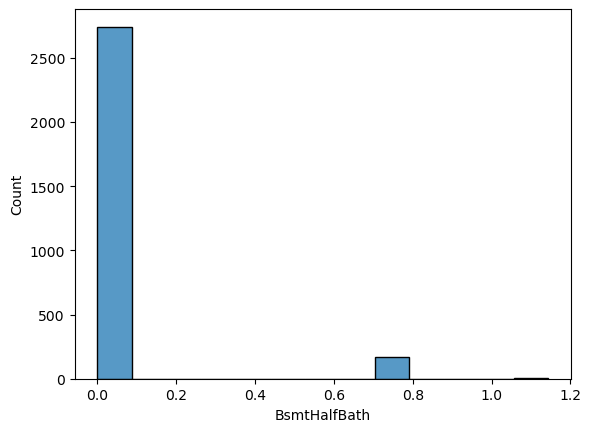

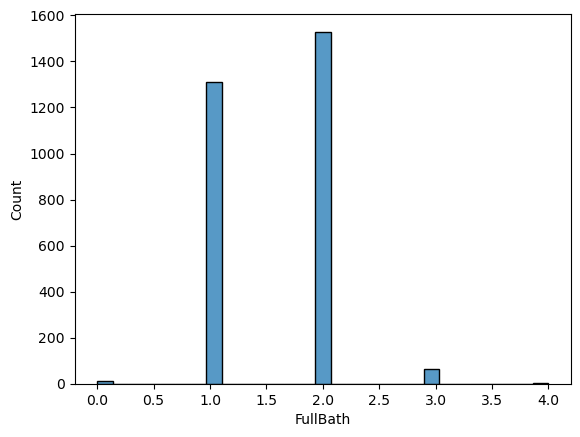

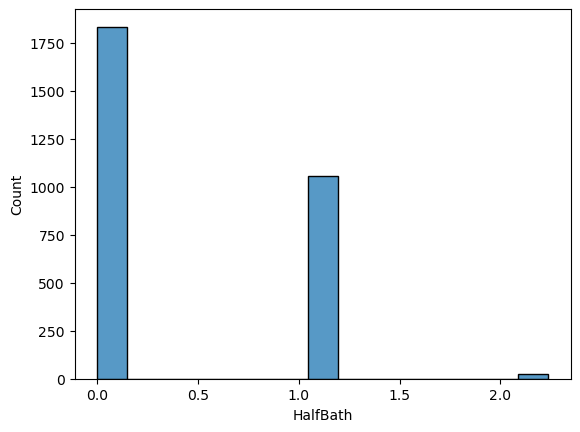

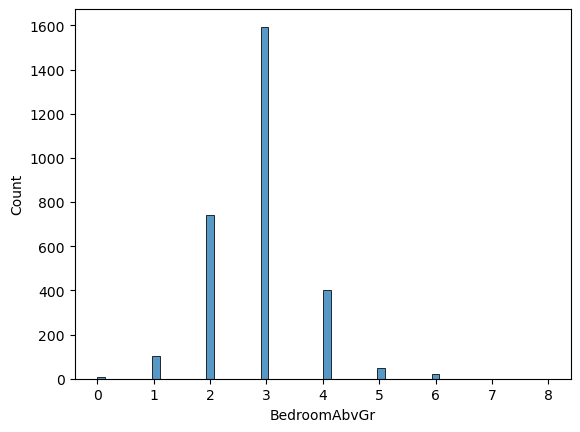

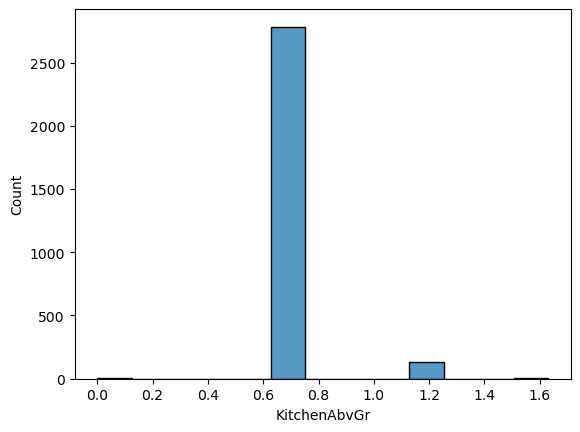

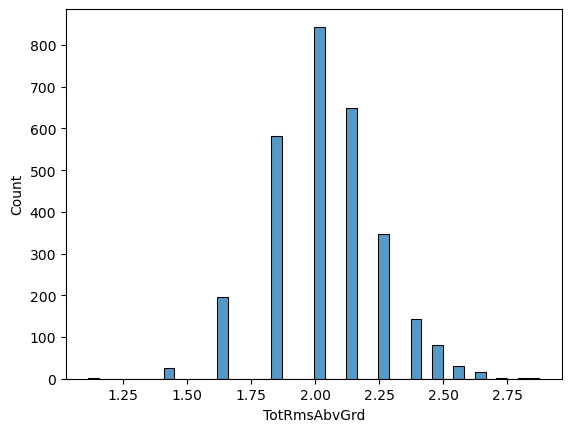

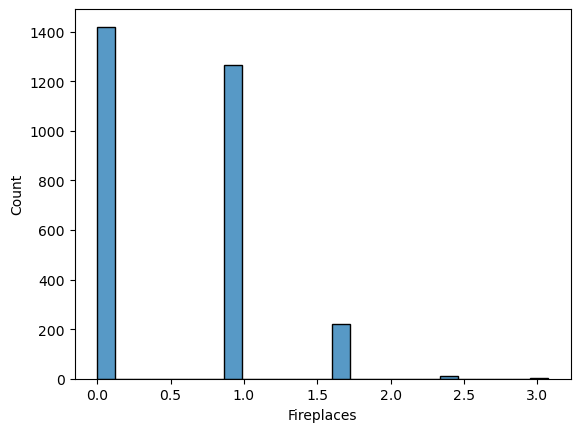

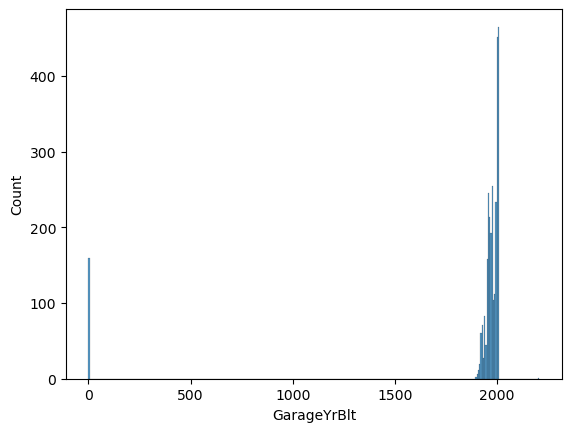

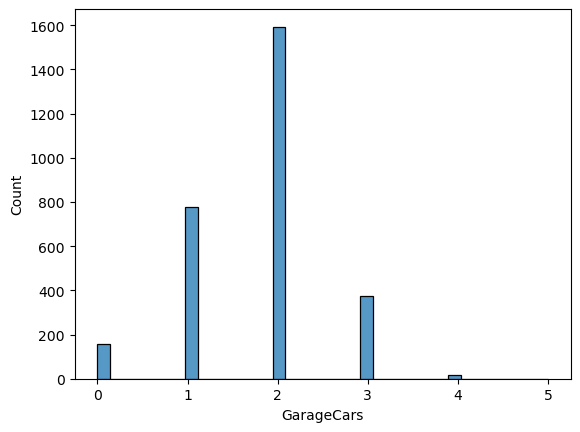

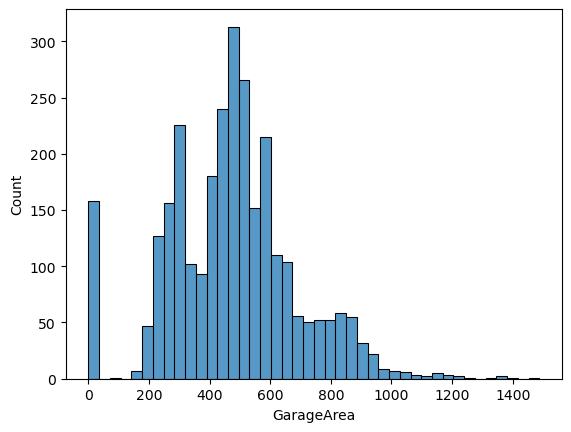

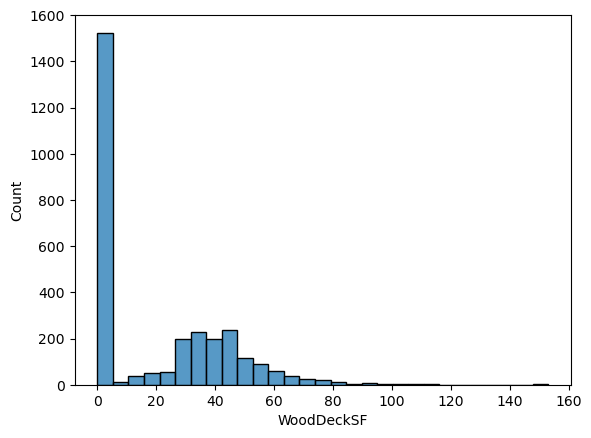

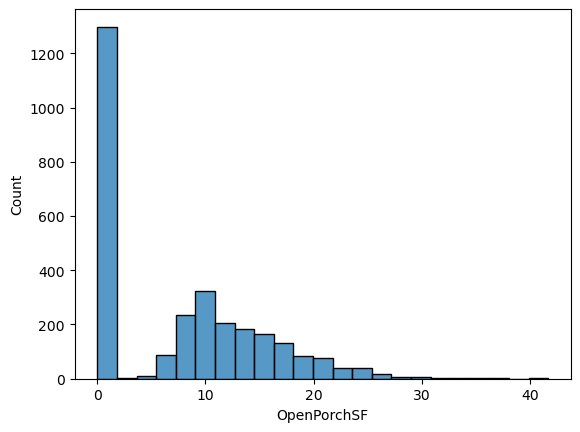

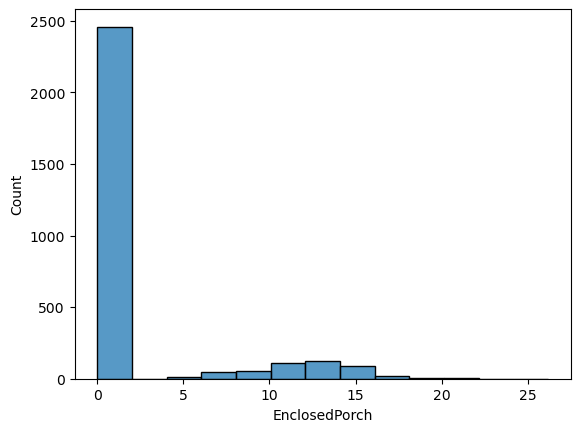

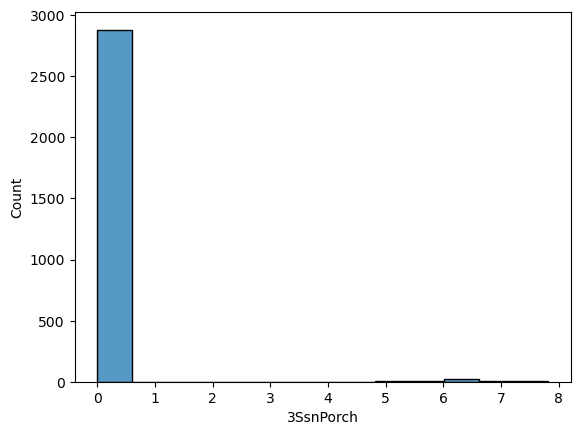

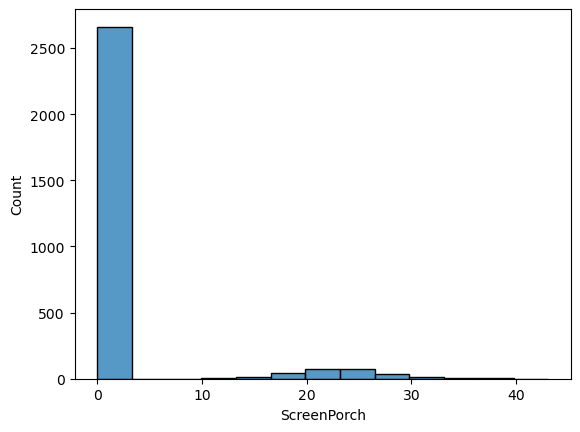

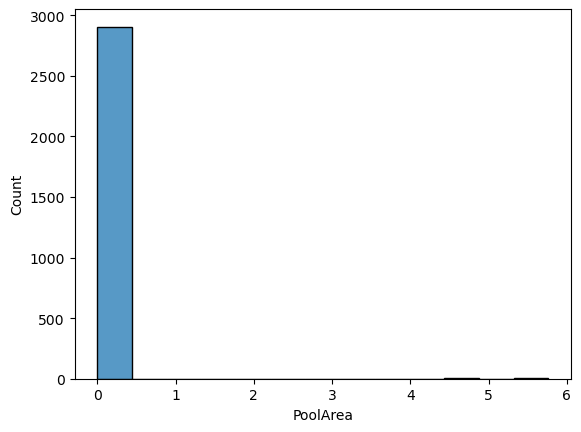

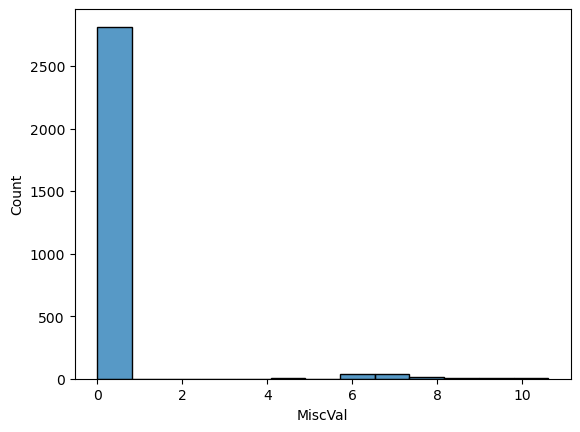

In [35]:
for feature in numeric_features:
    plt.subplots()
    sns.histplot(all_features[feature])

In [36]:
# Add logged feature column for skewed data and squared feature column of U-shape data
def log_feature(all_features, log_features):
    ''' skewed data '''
    m = all_features.shape[1]
    for f in log_features:
        all_features = all_features.assign(newcol=pd.Series(np.log(1.01 + all_features[f])).values)
        all_features.columns.values[-1] = f + '_1og'
    
    return all_features  
    
def square_feature(all_features, sq_features):
    ''' U-shape or inverted U-shape '''
    m = all_features.shape[1]
    for f in log_features:
        all_features = all_features.assign(newcol=pd.Series(all_features[f]*all_features[f]).values)
        all_features.columns.values[-1] = f + '_sq'
    
    return all_features

In [37]:
log_features = ['OverallQual', 'OverallCond', 'YearBuilt', 'GarageYrBlt', 'GarageArea']
square_features = ['YearRemodAdd']

log_feature(all_features, log_features)
square_feature(all_features, square_features)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,OverallQual_sq,OverallCond_sq,YearBuilt_sq,GarageYrBlt_sq,GarageArea_sq
0,60,RL,18.144573,13.833053,Pave,None,Reg,Lvl,AllPub,Inside,...,0.000000,2,2008,WD,Normal,49,15.932208,4012009,4012009.0,300304.0
1,20,RL,20.673625,14.117917,Pave,None,Reg,Lvl,AllPub,FR2,...,0.000000,5,2007,WD,Normal,36,36.000398,3904576,3904576.0,211600.0
2,60,RL,18.668046,14.476511,Pave,None,IR1,Lvl,AllPub,Inside,...,0.000000,9,2008,WD,Normal,49,15.932208,4004001,4004001.0,369664.0
3,70,RL,17.249651,14.106195,Pave,None,IR1,Lvl,AllPub,Corner,...,0.000000,2,2006,WD,Abnorml,49,15.932208,3667225,3992004.0,412164.0
4,60,RL,21.314282,15.022007,Pave,None,IR1,Lvl,AllPub,FR2,...,0.000000,12,2008,WD,Normal,64,15.932208,4000000,4000000.0,698896.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,160,RM,8.726308,10.765921,Pave,None,Reg,Lvl,AllPub,Inside,...,0.000000,6,2006,WD,Normal,16,28.601540,3880900,0.0,0.0
2913,160,RM,8.726308,10.723222,Pave,None,Reg,Lvl,AllPub,Inside,...,0.000000,4,2006,WD,Abnorml,16,15.932208,3880900,3880900.0,81796.0
2914,20,RL,31.755370,15.820338,Pave,None,Reg,Lvl,AllPub,Inside,...,0.000000,9,2006,WD,Abnorml,25,28.601540,3841600,3841600.0,331776.0
2915,85,RL,17.611139,14.307158,Pave,None,Reg,Lvl,AllPub,Inside,...,6.937474,7,2006,WD,Normal,25,15.932208,3968064,0.0,0.0


In [38]:
# Encode categorical Variables
print(f'Before get_dummies: {all_features.shape}')
all_features = pd.get_dummies(all_features).reset_index(drop=True)
print(f'After get_dummies: {all_features.shape}')


Before get_dummies: (2917, 79)
After get_dummies: (2917, 331)


In [39]:
dup = all_features.columns.duplicated().sum()
print(f'# of duplicated columns: {dup}')

# of duplicated columns: 0


In [40]:
train_X = all_features.iloc[:len(train_ID), :]
test_X = all_features.iloc[len(train_ID):, :]
train_X.shape, train_y.shape, test_X.shape

((1458, 331), (1458,), (1459, 331))

# Train

- Ridge regressor
- Suuport vector regressor
- LGBM
- XGBoost

In [41]:
kf = KFold(n_splits=12, random_state=302, shuffle=True)

def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, train_X, train_y, scoring='neg_mean_squared_error', cv=kf))
    
    return (rmse)

In [135]:
# LGBM
def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1000, 10000),
        'max_depth': trial.suggest_int('max_depth', 4, 16),
        'random_state': 302,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 8, 32),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.8, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 8),
        'min_child_samples': trial.suggest_int('min_child_samples', 16, 64),
        'learning_rate': trial.suggest_float('learning_rate', 1e-03, 1e-01)        
    }

    rmse = cv_rmse(lgb.LGBMRegressor(**params))
    
    return rmse.mean()

In [136]:
study = optuna.create_study(direction='minimize',sampler=TPESampler(seed=302))
study.optimize(lambda trial : objective_lgbm(trial), n_trials=100)

[I 2023-07-12 19:48:28,201] A new study created in memory with name: no-name-aa062eff-7ed9-494b-a105-c712d8d7f901
[I 2023-07-12 19:49:25,660] Trial 0 finished with value: 0.11819993517774148 and parameters: {'n_estimators': 6727, 'max_depth': 14, 'reg_alpha': 1.1879621668244605e-05, 'reg_lambda': 0.04536838353208099, 'num_leaves': 19, 'colsample_bytree': 0.7713953167687632, 'subsample': 0.9091333134157152, 'subsample_freq': 2, 'min_child_samples': 23, 'learning_rate': 0.026408044271137215}. Best is trial 0 with value: 0.11819993517774148.
[I 2023-07-12 19:49:48,607] Trial 1 finished with value: 0.11604248031854843 and parameters: {'n_estimators': 4943, 'max_depth': 4, 'reg_alpha': 0.07464181793733773, 'reg_lambda': 0.2895831674866888, 'num_leaves': 14, 'colsample_bytree': 0.5324290946753125, 'subsample': 0.8584252342902212, 'subsample_freq': 5, 'min_child_samples': 30, 'learning_rate': 0.01359731256631953}. Best is trial 1 with value: 0.11604248031854843.
[I 2023-07-12 19:49:55,775] Tr

In [137]:
print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))

Best trial: score 0.112838271233967,
params {'n_estimators': 1510, 'max_depth': 4, 'reg_alpha': 0.0006953911380050241, 'reg_lambda': 0.027805069305826376, 'num_leaves': 8, 'colsample_bytree': 0.5252360315844627, 'subsample': 0.833162988311333, 'subsample_freq': 3, 'min_child_samples': 18, 'learning_rate': 0.026160275419362257}


In [41]:
lgbm_rmse = 0.112838271233967
lgbm_params = {'n_estimators': 1510, 'max_depth': 4, 'reg_alpha': 0.0006953911380050241, 
               'reg_lambda': 0.027805069305826376, 'num_leaves': 8, 'colsample_bytree': 0.5252360315844627, 'random_state': 302, 
               'subsample': 0.833162988311333, 'subsample_freq': 3, 'min_child_samples': 18, 'learning_rate': 0.026160275419362257}

In [43]:
# XGBoost
def objective_xgb(trial):
    params = {
        'booster': 'gbtree', 
        'max_depth': trial.suggest_int('max_depth', 4, 16),
        'learning_rate': trial.suggest_float('learning_rate', 1e-03, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': 302
    }
    
    rmse = cv_rmse(xgb.XGBRegressor(**params))
    
    return rmse.mean()

In [44]:
study = optuna.create_study(direction='minimize',sampler=TPESampler(seed=302))
study.optimize(lambda trial : objective_xgb(trial), n_trials=100)

[I 2023-07-13 14:22:58,627] A new study created in memory with name: no-name-ee3c743a-e182-4115-a76c-1983b724dbcb
[I 2023-07-13 14:23:20,875] Trial 0 finished with value: 0.1353175863908237 and parameters: {'max_depth': 12, 'learning_rate': 0.24768766000312165, 'n_estimators': 407, 'min_child_weight': 8, 'gamma': 0.4744653174796793, 'subsample': 0.5473627272021511, 'colsample_bytree': 0.5502099014077904, 'reg_alpha': 0.14028523671538154, 'reg_lambda': 0.16167884428078896}. Best is trial 0 with value: 0.1353175863908237.
[I 2023-07-13 14:23:24,598] Trial 1 finished with value: 0.15965290836903012 and parameters: {'max_depth': 7, 'learning_rate': 0.13200116634266365, 'n_estimators': 135, 'min_child_weight': 8, 'gamma': 0.830795064557004, 'subsample': 0.2548324550907546, 'colsample_bytree': 0.07420960745711878, 'reg_alpha': 0.29920490973659514, 'reg_lambda': 0.5187702777774492}. Best is trial 0 with value: 0.1353175863908237.
[I 2023-07-13 14:23:42,951] Trial 2 finished with value: 0.1453

In [45]:
print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))

Best trial: score 0.11308362084952113,
params {'max_depth': 4, 'learning_rate': 0.05545301018606465, 'n_estimators': 389, 'min_child_weight': 4, 'gamma': 0.011584274257830885, 'subsample': 0.8163162337658724, 'colsample_bytree': 0.42568513349343234, 'reg_alpha': 0.3823379624196318, 'reg_lambda': 0.9500205438445088}


In [42]:
xgb_rmse = 0.11308362084952113
xgb_params = {'booster': 'gbtree', 'max_depth': 4, 'learning_rate': 0.05545301018606465, 'n_estimators': 389, 
              'min_child_weight': 4, 'gamma': 0.011584274257830885, 'subsample': 0.8163162337658724, 'random_state': 302, 
              'colsample_bytree': 0.42568513349343234, 'reg_alpha': 0.3823379624196318, 'reg_lambda': 0.9500205438445088}

In [50]:
# Ridge regressor
def objective_ridge(trial):
    params= {
        'alpha': trial.suggest_float('alpha', 0, 100)
    }
    
    rmse = cv_rmse(Ridge(**params))
    
    return rmse.mean()

In [51]:
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=302))
study.optimize(lambda trial: objective_ridge(trial), n_trials=100)

[I 2023-07-13 15:03:29,713] A new study created in memory with name: no-name-4c6a8c26-91d9-46a9-bc18-015b10169ca0
[I 2023-07-13 15:03:29,932] Trial 0 finished with value: 0.11229993541956661 and parameters: {'alpha': 63.6281212155408}. Best is trial 0 with value: 0.11229993541956661.
[I 2023-07-13 15:03:30,135] Trial 1 finished with value: 0.11333543547230061 and parameters: {'alpha': 82.5042341147564}. Best is trial 0 with value: 0.11229993541956661.
[I 2023-07-13 15:03:30,331] Trial 2 finished with value: 0.11045989045130888 and parameters: {'alpha': 34.164473442624995}. Best is trial 2 with value: 0.11045989045130888.
[I 2023-07-13 15:03:30,529] Trial 3 finished with value: 0.11288006575553629 and parameters: {'alpha': 73.96392561891005}. Best is trial 2 with value: 0.11045989045130888.
[I 2023-07-13 15:03:30,723] Trial 4 finished with value: 0.11128796177139062 and parameters: {'alpha': 46.91568863431104}. Best is trial 2 with value: 0.11045989045130888.
[I 2023-07-13 15:03:30,926]

In [52]:
print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))

Best trial: score 0.10927967770956741,
params {'alpha': 11.555016729474579}


In [45]:
ridge_rmse = 0.10927967770956741
ridge_params = {'alpha: 11.555016729474579', }

In [54]:
# SVR
def objective_svr(trial):
    params = {
        'epsilon': trial.suggest_float('epsilon', 1e-03, 0.1), 
        'C': trial.suggest_float('C', 0.1, 100), 
        'gamma': trial.suggest_float('gamma', 1e-04, 1),
    }
    
    rmse = cv_rmse(make_pipeline(RobustScaler(), SVR(**params)))
    
    return rmse.mean()

In [55]:
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=302))
study.optimize(lambda trial: objective_svr(trial), n_trials=100)

[I 2023-07-13 15:58:15,275] A new study created in memory with name: no-name-64f855d9-4e75-4e7b-b07f-811d7d49d12c
[I 2023-07-13 15:58:19,212] Trial 0 finished with value: 0.39183661408745746 and parameters: {'epsilon': 0.0639918400033854, 'C': 82.52172988064164, 'gamma': 0.34171056995280735}. Best is trial 0 with value: 0.39183661408745746.
[I 2023-07-13 15:58:23,288] Trial 1 finished with value: 0.39744020551139175 and parameters: {'epsilon': 0.07422428636272095, 'C': 46.96877294567673, 'gamma': 0.5428363544741726}. Best is trial 0 with value: 0.39183661408745746.
[I 2023-07-13 15:58:27,014] Trial 2 finished with value: 0.32933291030289397 and parameters: {'epsilon': 0.05502099014077903, 'C': 13.246964795824864, 'gamma': 0.15329563272359684}. Best is trial 2 with value: 0.32933291030289397.
[I 2023-07-13 15:58:30,969] Trial 3 finished with value: 0.18402691593890452 and parameters: {'epsilon': 0.026408044271137215, 'C': 43.86928601214749, 'gamma': 0.0393587414147646}. Best is trial 3 

In [56]:
print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))

Best trial: score 0.10903106114718593,
params {'epsilon': 0.04719171620059693, 'C': 67.69756925770727, 'gamma': 0.00031849501965791074}


In [52]:
svr_params = {'epsilon': 0.04719171620059693, 'C': 67.69756925770727, 'gamma': 0.00031849501965791074}
svr_rmse = 0.10903106114718593

In [53]:
xgboost = XGBRegressor(**xgb_params)
lightgbm = LGBMRegressor(**lgbm_params)
ridge = Ridge(alpha=11.555016729474579)
# ridge = Ridge(**ridge_params)
svr = SVR(**svr_params)

In [55]:
# StackingCVRegressor
stack_cvr = StackingCVRegressor(regressors=(xgboost, lightgbm, ridge, svr), meta_regressor=xgboost, use_features_in_secondary=True)
stack_model = stack_cvr.fit(np.array(train_X), np.array(train_y))

# LGBM
lightgbm.fit(train_X, train_y)

# XGBoost
xgboost.fit(train_X, train_y)

# Ridge
ridge.fit(train_X, train_y)

# SVR
svr.fit(train_X, train_y)

SVR(C=67.69756925770727, epsilon=0.04719171620059693,
    gamma=0.00031849501965791074)

In [58]:
def rmse(pred_y ,y):
    return np.sqrt(mean_squared_error(pred_y, y))

In [59]:
rmse(stack_model.predict(train_X), train_y)

0.058867491929238944

In [69]:
scores = {}
scores['LGBM'] = lgbm_rmse
scores['XGB'] = xgb_rmse
scores['Ridge'] = ridge_rmse
scores['SVR'] = svr_rmse
scores['Stack_model'] = rmse(stack_model.predict(train_X), train_y)

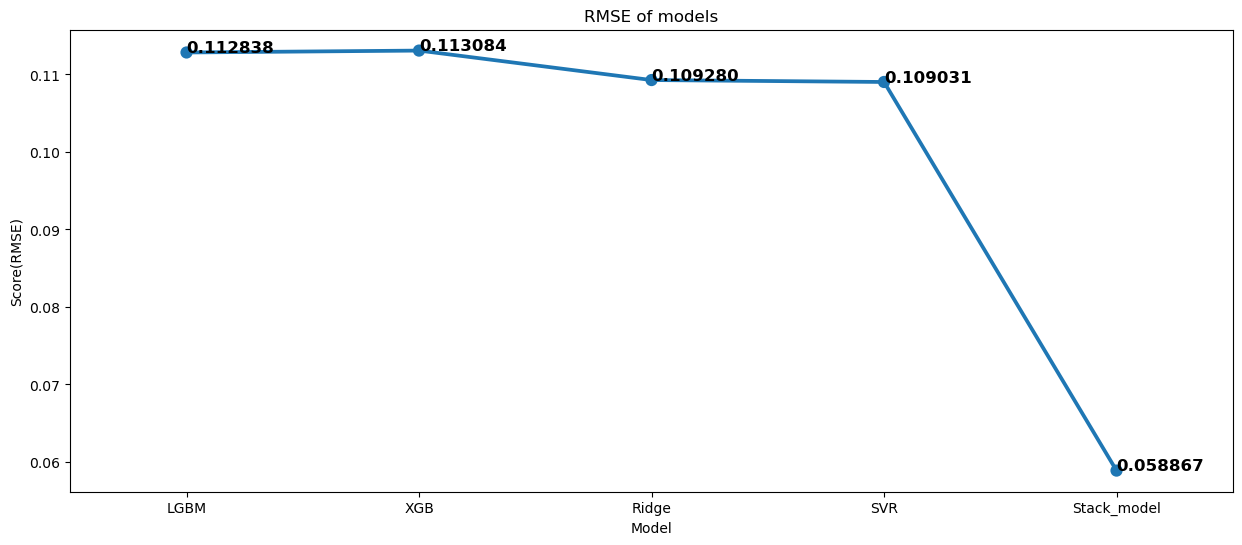

In [72]:
plt.figure(figsize=(15, 6))
f = sns.pointplot(x=list(scores.keys()), y=[score for score in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    f.text(i, score, '{:.6f}'.format(score), horizontalalignment='left', size='large', color='black', weight='semibold')
plt.xlabel('Model')
plt.ylabel('Score(RMSE)')
plt.title('RMSE of models')

plt.show()

In [73]:
submission = pd.read_csv('data/sample_submission.csv')

In [81]:
submission.iloc[:, 1] = np.floor(np.expm1(stack_model.predict(test_X)))

In [80]:
submission.to_csv('submission1.csv', index=False)